# Наивный Байес и спам
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW08] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer

In [2]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^b['\"](ham|spam)['\"][,\t\s]+b['\"](.*)['\"]$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [3]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [4]:
X, y = read_dataset("../data/spam.csv")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

C:\Users\Nikita\Anaconda3\envs\ForHW08\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [6]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha  # Параметр аддитивной регуляризации

    def fit(self, X, y):
        self.classes = np.unique(y)
        sums = np.array([np.sum(X[y == l], axis=0) + self.alpha for l in self.classes])
        self.logprobas = np.log(sums / np.sum(sums, axis=1).reshape(-1, 1))
        self.class_logprobas = np.log(np.array([len(y[(y == l)]) for l in self.classes]) / len(y))

    def predict(self, X):
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]

    def log_proba(self, X):
        return np.array(
            [[self.class_logprobas[i] + np.sum(x * self.logprobas[i]) for i in range(len(self.classes))] for x in X])


### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [7]:
class BoW:
    def __init__(self, X, voc_limit=1000):
        bag = dict()
        for x in X:
            for w in re.split('[^a-zA-Z]', x.lower()):
                if w not in bag.keys():
                    bag[w] = 1
                else:
                    bag[w] += 1

        if '' in bag.keys():
            del bag['']
        self.bag = np.array(sorted(bag.items(), key=lambda x: x[1], reverse=True))[:voc_limit, 0]

    def transform(self, X):
        ans = []
        for x in X:
            words = list(re.split('[^a-zA-Z]', x.lower()))
            ans.append([words.count(self.bag[i]) for i in range(len(self.bag))])
        return np.array(ans)

In [8]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [9]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.99375, 'spam': 0.9230769230769231},
 {'ham': 0.9875776397515528, 'spam': 0.96},
 0.9838709677419355)

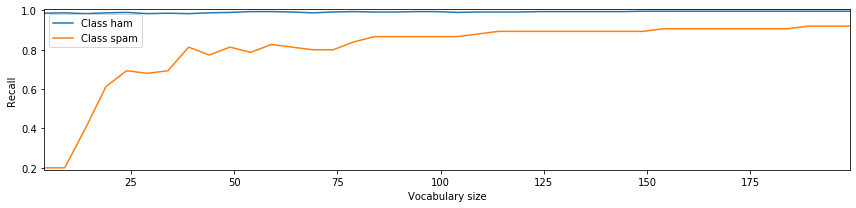

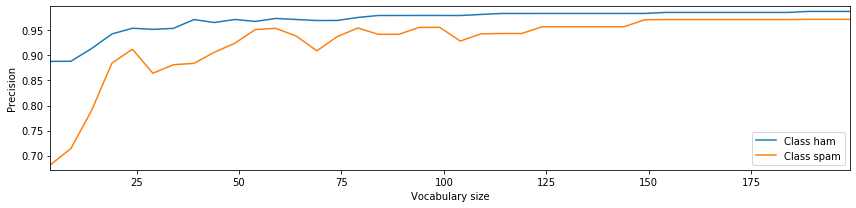

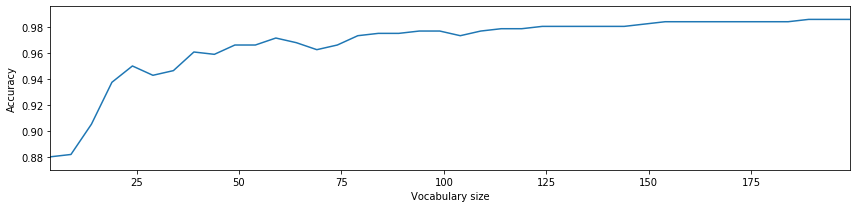

In [10]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [14]:
class BowStem:
    def __init__(self, X, voc_limit=1000):
        self.stemmer = SnowballStemmer('english')
        bag = dict()
        for x in X:
            for w in re.split('[^a-zA-Z]', x.lower()):
                stem = self.stemmer.stem(w)
                if stem not in bag.keys():
                    bag[stem] = 1
                else:
                    bag[stem] += 1

        if '' in bag.keys():
            del bag['']
        self.bag = np.array(sorted(bag.items(), key=lambda x: x[1], reverse=True))[:voc_limit, 0]

    def transform(self, X):
        ans = []
        for x in X:
            words = list(re.split('[^a-zA-Z]', x.lower()))
            words = [self.stemmer.stem(w) for w in words]
            ans.append([words.count(self.bag[i]) for i in range(len(self.bag))])
        return np.array(ans)

In [15]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [16]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9958419958419958, 'spam': 0.948051948051948},
 {'ham': 0.9917184265010351, 'spam': 0.9733333333333334},
 0.989247311827957)

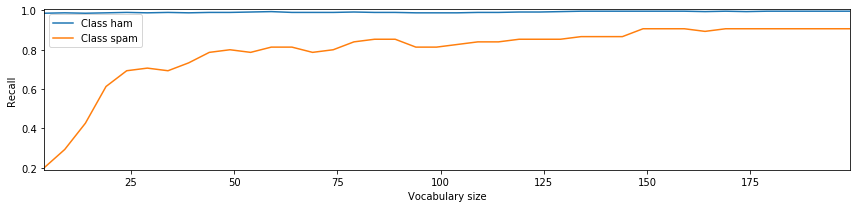

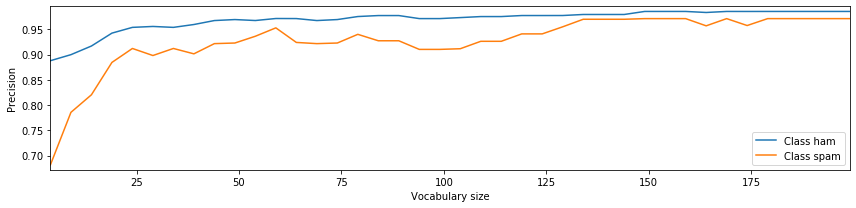

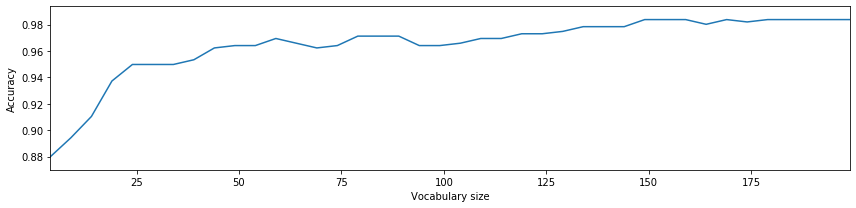

In [17]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)